# Baseline model

This notebook contains the model that we will use as a baseline to compare all others. The architecture we will deploy is a simple CNN. This model will be trained and tested over partitions of the the COCO 2014 training dataset. 

TO DO:
- add docstrings to functions
- fix plots of a,b and ab channels
- create separate library for dataset, models and auxiliary functions (useful when we'll have multiple models). no need to do it now, but certainly to do by the time we start running the different models.
- fix predicted images (see output alla fine)

A TIP:
- put const variables in grassetto (per esempio NUM EPOCHS, BATCH SIZE, e altre cose simili). è utile per differenziare cose della rete da altre variabili generiche
- start from load weights part to avoid retraining.

## Libraries import

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2lab, lab2rgb
from skimage import color
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data import

We build a class to import the dataset and handle the COCO images in the desired formats.

In [2]:
class CocoDataset(Dataset):
    def __init__(self, root, transform = None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, f) for f in os.listdir(root) if f.endswith('.jpg')]
        if not self.image_paths:
            raise ValueError("No images found in the directory. Check the directory path.")
        print(f"Found {len(self.image_paths)} images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        try:
            image_path = self.image_paths[index]
            image = Image.open(image_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            image_np = np.array(image.permute(1, 2, 0))
            lab_image = rgb2lab(image_np)
            l_channel = torch.from_numpy(lab_image[:, :, 0] / 100).unsqueeze(0).float()
            ab_channels = torch.from_numpy((lab_image[:, :, 1:] + 128) / 255).permute(2, 0, 1).float()  
            return image, l_channel, ab_channels
        except Exception as e:
            print(f"Error processing index {index}: {e}")
            raise

    def get_channels_for_image(self, index):
        # Directly use the output from __getitem__
        _, l_channel, ab_channels = self.__getitem__(index)
        # Directly return the already computed L, A, B, and AB channels
        a_channel = ab_channels[0, :, :]  # Assuming A is the first channel in AB tensor
        b_channel = ab_channels[1, :, :]  # Assuming B is the second channel in AB tensor
        return l_channel, a_channel, b_channel, ab_channels
        
    def plot_l(self, index):
        _, l_channel, _ = self[index]  # Unpack to get the L channel
        l_channel = l_channel.squeeze()  # Remove unnecessary dimension
        plt.figure(figsize=(6, 6))
        plt.imshow(l_channel, cmap='gray')
        plt.axis('off')
        plt.show()

    def plot_a(self, index):
        _, a_channel, _, _ = self.get_channels_for_image(index)
        plt.figure(figsize=(6, 6))
        plt.imshow(a_channel, cmap='coolwarm') # needs fix here
        plt.axis('off')
        plt.show()

    def plot_b(self, index):
        _, _, b_channel, _ = self.get_channels_for_image(index)
        plt.figure(figsize=(6, 6))
        plt.imshow(b_channel, cmap='coolwarm') # needs fix here
        plt.axis('off')
        plt.show()
    
    def plot_ab(self, index, l_values=[25, 50, 75]):
        _, _, _, ab_channels = self.get_channels_for_image(index)  # Extract the AB channels from the dataset
        
        # Ensure AB channels are in the correct shape (256, 256, 2)
        if ab_channels.shape[0] == 2:  # Assuming ab_channels shape is initially (2, 256, 256)
            ab_channels = ab_channels.permute(1, 2, 0)  # Change to (256, 256, 2)
        
        for l in l_values:
            lab_image = np.zeros((ab_channels.shape[0], ab_channels.shape[1], 3))
            lab_image[:, :, 0] = l  # Set the L channel to one of the specified L values
            lab_image[:, :, 1:] = ab_channels * 255 - 128  # Scale AB channels correctly for lab2rgb
            
            rgb_image = lab2rgb(lab_image)
            
            plt.figure(figsize=(6, 6))
            plt.imshow(rgb_image)
            plt.title(f'L = {l}')
            plt.axis('off')
            plt.show()
    
    def plot_rgb(self, index):
        rgb_image, _, _ = self[index]  # Unpacking to get the RGB image
        rgb_image = rgb_image.permute(1, 2, 0)  # Convert from CxHxW to HxWxC for plotting
        plt.figure(figsize=(6, 6))
        plt.imshow(rgb_image)
        plt.axis('off')
        plt.show()

Resize the images and convert them into tensors.

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to a fixed size
    transforms.ToTensor(),  # Convert the image to a tensor
])

Import the dataset.

In [5]:
path_sandro = "coco/images/train2014"
path_diego = "C:/Users/diego/coco/images/train2014/train2014"
dataset = CocoDataset(root=path_sandro, transform=transform)

Found 82783 images.


Observe the dataset size.

In [6]:
image, l_channel, ab_channel = dataset[0]
print(f"Number of images: {len(dataset)}\n L channel shape: {l_channel.shape}\n AB channel shape:{ab_channel.shape}")

Number of images: 82783
 L channel shape: torch.Size([1, 64, 64])
 AB channel shape:torch.Size([2, 64, 64])


Let's look at the first image in the dataset.

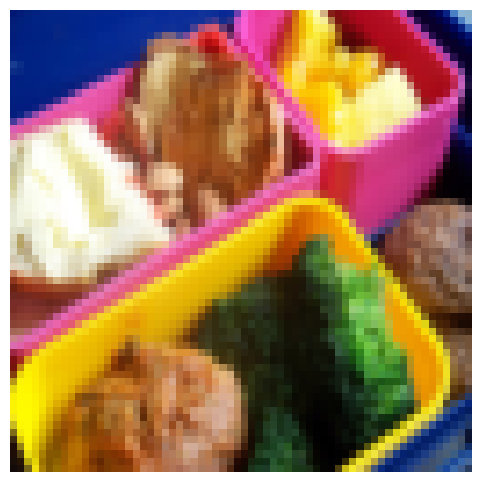

In [7]:
dataset.plot_rgb(0)

Let's convert this image in a black-and-white format using a previously defined function.

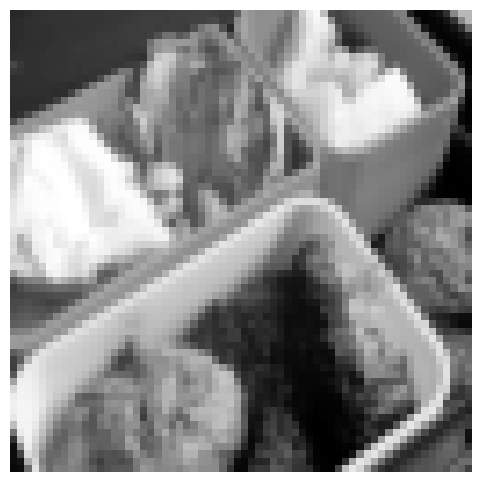

In [8]:
dataset.plot_l(0)

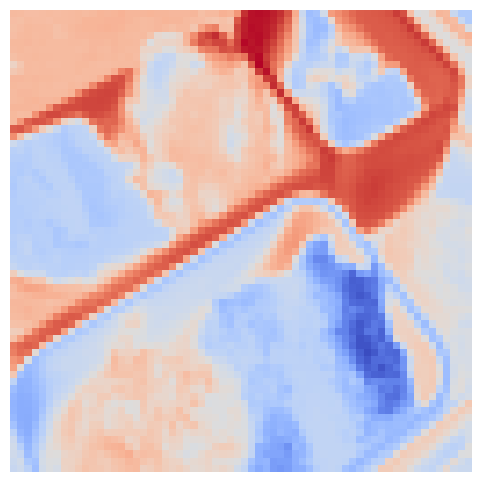

In [9]:
dataset.plot_a(0)

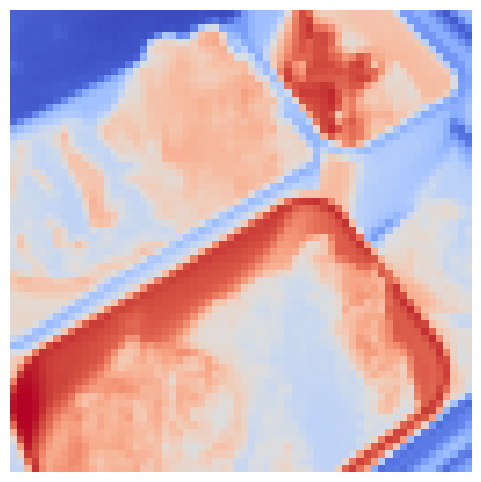

In [10]:
dataset.plot_b(0)

C:\Users\sandr\AppData\Local\Temp\ipykernel_14232\24351217.py:70: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 506 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)


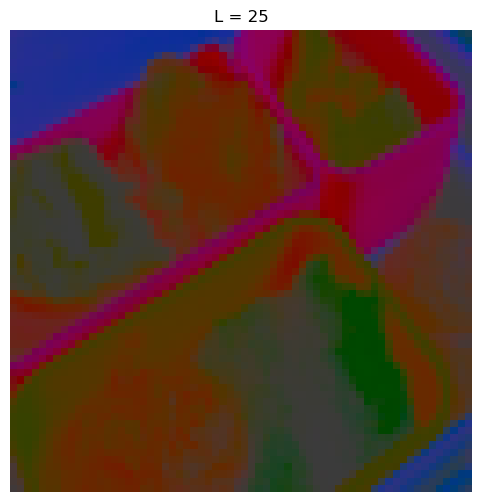

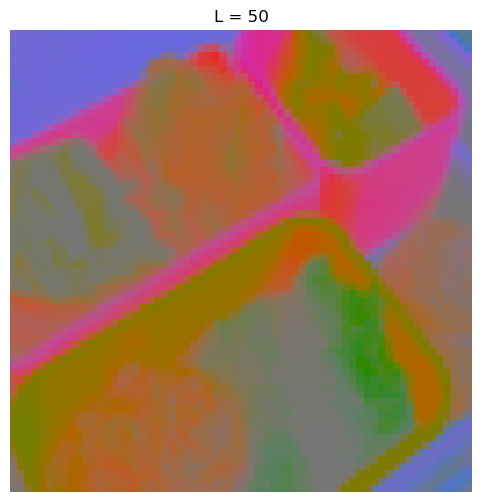

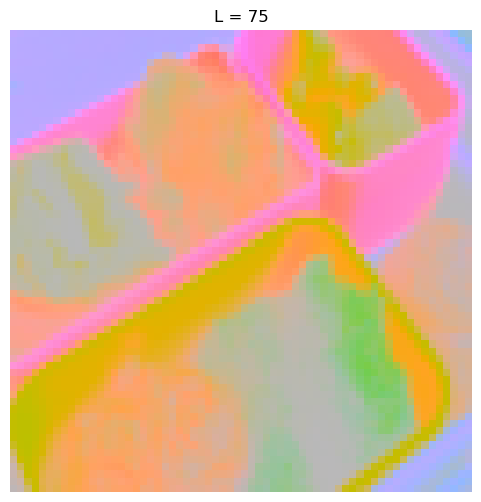

In [11]:
dataset.plot_ab(0)

We build a function that will later turn useful: given an L channel, and an AB channel, we reconstruct the original image

In [35]:
def reconstruct_lab(l, ab):
    a = ab[0]
    b = ab[1]
    l = l.squeeze()
    lab_image = torch.stack((l, a, b), dim=0)

    lab_image_np = lab_image.permute(1, 2, 0).cpu().numpy()

    # Denormalize LAB channels
    l_channel = lab_image_np[:, :, 0] * 100  # Revert L channel normalization
    ab_channels = lab_image_np[:, :, 1:] * 255 - 127  # Revert A and B channel normalization

    # Stack L, A, B channels
    lab_image_reconstructed = np.zeros((lab_image_np.shape[0], lab_image_np.shape[1], 3))
    lab_image_reconstructed[:, :, 0] = l_channel
    lab_image_reconstructed[:, :, 1:] = ab_channels

    # Convert LAB image to RGB
    rgb_image = lab2rgb(lab_image_reconstructed)

    # Display the RGB image
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.show()

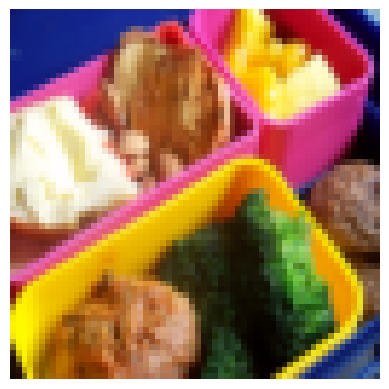

In [13]:
L, _, _, AB = dataset.get_channels_for_image(0)
reconstruct_lab(L, AB)

## Data preparation

We split our dataset in train and test data.

In [14]:
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size

In [15]:
torch.manual_seed(42)
train, test = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test, batch_size=64, shuffle=True, num_workers=4)

## CNN Model

For the moment, we will work with a small subset of the training data

In [16]:
torch.manual_seed(42)
train_size = 5000
small_train, _ = random_split(train, [train_size, len(train) - train_size])
small_train_loader = DataLoader(small_train, batch_size=64, shuffle=True, num_workers=0)
test_size = 1000
small_test, _ = random_split(test, [test_size, len(test) - test_size])
small_test_loader = DataLoader(small_test, batch_size=64, shuffle=True, num_workers=0)

In [17]:
class ColorizationCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(32, 2, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        return self.sigmoid(x)

## Training

In [18]:
model = ColorizationCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [19]:
NUM_EPOCHS = 10
train_losses = []
test_losses = []

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    test_loss = 0.0

    # train loop
    model.train()
    progress_bar = tqdm(small_train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', leave=True)
    for _, l_channels, ab_channels in progress_bar:
        l_channels = l_channels.to(device)
        ab_channels = ab_channels.to(device)
        
        optimizer.zero_grad()
        outputs = model(l_channels)
        loss = criterion(outputs, ab_channels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=(running_loss / (progress_bar.n + 1)))
    
    train_losses.append(running_loss / len(small_train_loader))
    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}")
    
    # test loop
    model.eval()
    with torch.no_grad():
        for _, l_channels, ab_channels in tqdm(small_test_loader, desc='Testing', leave=True):
            l_channels = l_channels.to(device)
            ab_channels = ab_channels.to(device)
            
            outputs = model(l_channels)
            loss = criterion(outputs, ab_channels)
            test_loss += loss.item()
        
    test_loss /= len(small_test_loader)
    test_losses.append(test_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {test_loss}")
    
print('Finished Training')

Epoch 1/10: 100%|██████████| 79/79 [00:33<00:00,  2.35it/s, loss=0.0107]


Epoch 1, Train Loss: 0.010745296814726501


Testing: 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]


Epoch 1, Validation Loss: 0.0032477268105139956


Epoch 2/10: 100%|██████████| 79/79 [00:30<00:00,  2.60it/s, loss=0.00355]


Epoch 2, Train Loss: 0.0035528539461849988


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]


Epoch 2, Validation Loss: 0.0032516119681531563


Epoch 3/10: 100%|██████████| 79/79 [00:30<00:00,  2.59it/s, loss=0.00356]


Epoch 3, Train Loss: 0.0035595923037374322


Testing: 100%|██████████| 16/16 [00:04<00:00,  3.27it/s]


Epoch 3, Validation Loss: 0.0032496261555934325


Epoch 4/10: 100%|██████████| 79/79 [00:30<00:00,  2.55it/s, loss=0.00355]


Epoch 4, Train Loss: 0.003550309466811109


Testing: 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]


Epoch 4, Validation Loss: 0.0032546160800848156


Epoch 5/10: 100%|██████████| 79/79 [00:30<00:00,  2.59it/s, loss=0.00359]


Epoch 5, Train Loss: 0.003590111505782491


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 5, Validation Loss: 0.0032354751747334376


Epoch 6/10: 100%|██████████| 79/79 [00:30<00:00,  2.56it/s, loss=0.00355]


Epoch 6, Train Loss: 0.003546004445893289


Testing: 100%|██████████| 16/16 [00:04<00:00,  3.23it/s]


Epoch 6, Validation Loss: 0.003251066882512532


Epoch 7/10: 100%|██████████| 79/79 [00:32<00:00,  2.41it/s, loss=0.00355]


Epoch 7, Train Loss: 0.0035488059526144326


Testing: 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


Epoch 7, Validation Loss: 0.003257681761169806


Epoch 8/10: 100%|██████████| 79/79 [00:32<00:00,  2.42it/s, loss=0.00355]


Epoch 8, Train Loss: 0.0035546187199416417


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 8, Validation Loss: 0.0032476150518050417


Epoch 9/10: 100%|██████████| 79/79 [00:31<00:00,  2.48it/s, loss=0.00359]


Epoch 9, Train Loss: 0.0035868753160385393


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]


Epoch 9, Validation Loss: 0.003262564554461278


Epoch 10/10: 100%|██████████| 79/79 [00:30<00:00,  2.55it/s, loss=0.00356]


Epoch 10, Train Loss: 0.003555544056705659


Testing: 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]

Epoch 10, Validation Loss: 0.0032447414560010657
Finished Training


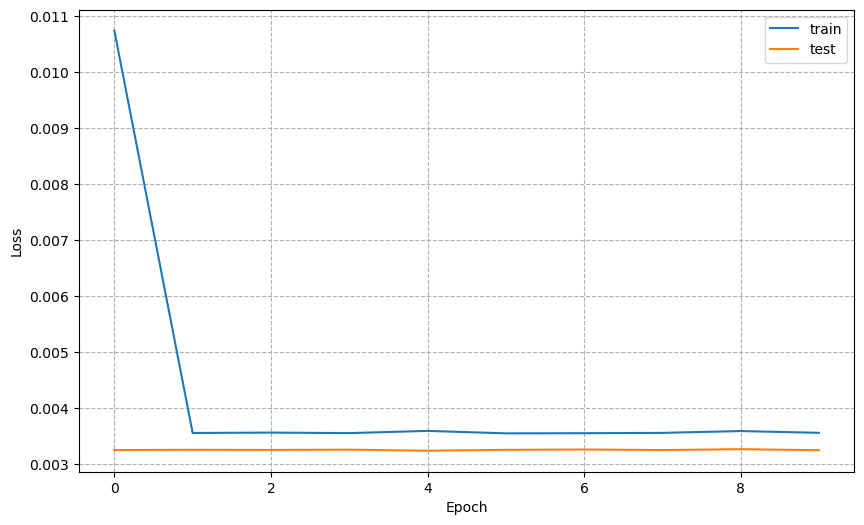

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(linestyle = "--")
plt.legend()
plt.show()

# Save and Load Model

In [49]:
# save weights
# run only if necessary... scriviamo una funzione anche per questa in futuro
from pathlib import Path
PATH = Path("models") 
PATH.mkdir(parents=True, # create parent directories if needed
           exist_ok=True # if models directory already exists, don't error
)
MODEL_NAME = "cnn_basic_1.pth"
MODEL_PATH = PATH / MODEL_NAME
torch.save(obj=model.state_dict(), f=MODEL_PATH)
print(f"Model saved to {MODEL_PATH} succesfully!")

Model saved to models\cnn_basic_1.pth succesfully!


In [48]:
model._get_name()

'ColorizationCNN'

In [51]:
# load model
# start from here if you don't want to do training again
loaded_model = ColorizationCNN() # create instance
loaded_model.load_state_dict(torch.load(f=MODEL_PATH)) # upload weights
print(f"{loaded_model._get_name()} model uploaded succesfully!")
loaded_model= loaded_model.to(device) # send it to gpu

ColorizationCNN model uploaded succesfully!


# Test with Image

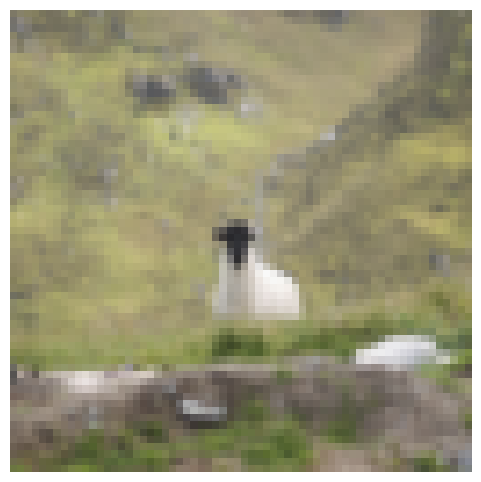

In [24]:
dataset.plot_rgb(50001)

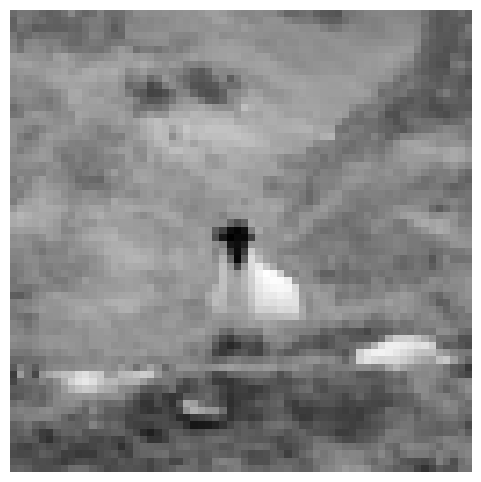

In [25]:
dataset.plot_l(50001)

In [52]:
l_test = dataset.get_channels_for_image(50001)[0].to(device)
ab_pred_test = loaded_model(l_test)

In [53]:
ab_pred_test.shape

torch.Size([2, 64, 64])

In [54]:
ab_pred_test

tensor([[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

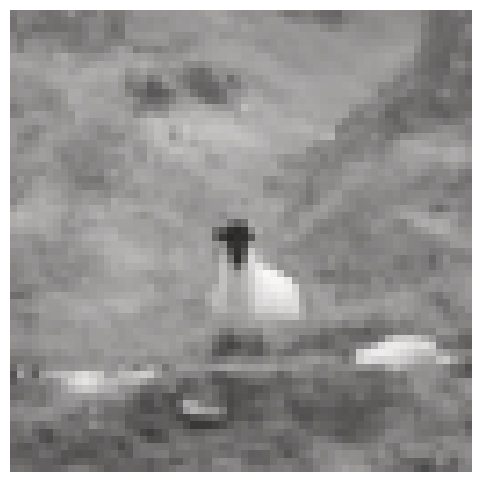

In [55]:
reconstruct_lab(l_test.detach().cpu(), ab_pred_test.detach().cpu())
# non colorata...

In [56]:
ab_pred_test.unique() # tensor([0.5000], device='cuda:0', grad_fn=<Unique2Backward0>), sono tutti 0.5
# questo spiegherebbe la loss così basssa.... non sta colorando

tensor([0.5000], device='cuda:0', grad_fn=<Unique2Backward0>)